In [1]:
import datetime
import hashlib
import itertools
import json
import os
import pickle
import re
import warnings

from collections import defaultdict, namedtuple
from copy import copy
from pathlib import Path

In [2]:
import joblib

import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import pyplot as plt

import netCDF4
from netCDF4 import Dataset

import numpy as np

import pandas as pd

import scipy as sp

import sklearn
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

import tqdm

In [3]:
TrajectoryPaths = namedtuple("TrajectoryPaths", ["date", "out", "aer", "ant", "bio", "met"])
TrajectoryDatasets = namedtuple("TrajectoryDatasets", ["date", "out", "aer", "ant", "bio", "met"])
MLDataset = namedtuple("MLDataset", ["date", "paths", "X_raw", "Y_raw", "X_train", "X_valid", "X_test", "Y_train", "Y_valid", "Y_test", "X_scaler", "Y_scaler"])

In [4]:
OUTDIR_PATTERN = re.compile(r"(\d{4})(\d{2})(\d{2})_T(\d{2})")

In [5]:
traj_datetimes = dict()

base = Path.cwd().parent / "trajectories"

for child in (base / "outputs" / "baseline").iterdir():
    if not child.is_dir():
        continue
    
    match = OUTDIR_PATTERN.match(child.name)
    
    if match is None:
        continue
        
    date = datetime.datetime(
        year=int(match.group(1)),
        month=int(match.group(2)),
        day=int(match.group(3)),
        hour=int(match.group(4)),
    )
    
    out_path = child / "output.nc"
    aer_path = (
        base / "inputs" / "baseline" / "HYDE_BASE_Y2018" /
        f"OUTPUT_bwd_{date.strftime('%Y%m%d')}" /
        "EMISSIONS_0422" /
        f"{date.strftime('%Y%m%d')}_7daybwd_Hyde_traj_AER_{24-date.hour:02}_L3.nc"
    )
    ant_path = (
        base / "inputs" / "baseline" / "HYDE_BASE_Y2018" /
        f"OUTPUT_bwd_{date.strftime('%Y%m%d')}" /
        "EMISSIONS_0422" /
        f"{date.strftime('%Y%m%d')}_7daybwd_Hyde_traj_ANT_{24-date.hour:02}_L3.nc"
    )
    bio_path = (
        base / "inputs" / "baseline" / "HYDE_BASE_Y2018" /
        f"OUTPUT_bwd_{date.strftime('%Y%m%d')}" /
        "EMISSIONS_0422" /
        f"{date.strftime('%Y%m%d')}_7daybwd_Hyde_traj_BIO_{24-date.hour:02}_L3.nc"
    )
    met_path = (
        base / "inputs" / "baseline" / "HYDE_BASE_Y2018" /
        f"OUTPUT_bwd_{date.strftime('%Y%m%d')}" /
        "METEO" /
        f"METEO_{date.strftime('%Y%m%d')}_R{24-date.hour:02}.nc"
    )
    
    if (
        (not out_path.exists()) or (not aer_path.exists()) or
        (not ant_path.exists()) or (not bio_path.exists()) or
        (not met_path.exists())
    ):
        raise Exception(out_path, aer_path, ant_path, bio_path, met_path)
    
    traj_datetimes[date] = TrajectoryPaths(
        date=date, out=out_path, aer=aer_path, ant=ant_path, bio=bio_path, met=met_path,
    )

traj_dates = sorted(set(d.date() for d in traj_datetimes.keys()))

In [6]:
def load_trajectory_dataset(paths: TrajectoryPaths) -> TrajectoryDatasets:
    outds = Dataset(paths.out, "r", format="NETCDF4")
    aerds = Dataset(paths.aer, "r", format="NETCDF4")
    antds = Dataset(paths.ant, "r", format="NETCDF4")
    biods = Dataset(paths.bio, "r", format="NETCDF4")
    metds = Dataset(paths.met, "r", format="NETCDF4")
    
    return TrajectoryDatasets(
        date=paths.date, out=outds, aer=aerds, ant=antds, bio=biods, met=metds,
    )

In [7]:
def get_ccn_concentration(ds: TrajectoryDatasets):
    ccn_bin_indices, = np.nonzero(ds.out["dp_dry_fs"][:].data > 80e-9)
    ccn_concentration = np.sum(ds.out["nconc_par"][:].data[:,ccn_bin_indices,:], axis=1)
    
    return pd.DataFrame({
        "time": np.repeat(get_output_time(ds), ds.out["lev"].shape[0]),
        "level": np.tile(ds.out["lev"][:].data, ds.out["time"].shape[0]),
        "ccn": ccn_concentration.flatten(),
    }).set_index(["time", "level"])

In [8]:
def get_output_time(ds: TrajectoryDatasets):
    fdom = datetime.datetime.strptime(
        ds.out["time"].__dict__["first_day_of_month"], "%Y-%m-%d %H:%M:%S",
    )
    dt = (ds.date - fdom).total_seconds()
    
    out_t = ds.out["time"][:].data
    
    return out_t - dt

def interpolate_meteorology_values(ds: TrajectoryDatasets, key: str):
    out_t = get_output_time(ds)
    out_h = ds.out["lev"][:].data
    
    met_t = ds.met["time"][:].data
    met_h = ds.met["lev"][:].data
    
    met_t_h = ds.met[key][:]
    
    met_t_h_int = sp.interpolate.interp2d(
        x=met_h, y=met_t, z=met_t_h, kind="linear", bounds_error=False, fill_value=0.0,
    )
    
    return met_t_h_int(x=out_h, y=out_t)

def interpolate_meteorology_time_values(ds: TrajectoryDatasets, key: str):
    out_t = get_output_time(ds)
    out_h = ds.out["lev"][:].data
    
    met_t = ds.met["time"][:].data
    
    met_t_v = ds.met[key][:]
    
    met_t_int = sp.interpolate.interp1d(
        x=met_t, y=met_t_v, kind="linear", bounds_error=False, fill_value=0.0,
    )
    
    return np.repeat(
        met_t_int(x=out_t).reshape(-1, 1),
        out_h.shape[0], axis=1,
    )

def interpolate_biogenic_emissions(ds: TrajectoryDatasets, key: str):
    out_t = get_output_time(ds)
    out_h = ds.out["lev"][:].data
    
    # depth of each box layer, assuming level heights are midpoints and end points are clamped
    out_d = (np.array(list(out_h[1:])+[out_h[-1]]) - np.array([out_h[0]]+list(out_h[:-1]))) / 2.0
    
    bio_t = ds.bio["time"][:].data
    
    # Biogenic emissions are limited to boxes at <= 10m height
    biogenic_emission_layers = np.nonzero(out_h <= 10.0)
    biogenic_emission_layer_height_cumsum = np.cumsum(out_d[biogenic_emission_layers])
    biogenic_emission_layer_proportion = biogenic_emission_layer_height_cumsum / biogenic_emission_layer_height_cumsum[-1]
    num_biogenic_emission_layers = sum(out_h <= 10.0)
    
    bio_t_h = np.zeros(shape=(out_t.size, out_h.size))
    
    bio_t_int = sp.interpolate.interp1d(
        x=bio_t, y=ds.bio[key][:], kind="linear", bounds_error=False, fill_value=0.0,
    )
    
    # Split up the biogenic emissions relative to the depth of the boxes
    bio_t_h[:,biogenic_emission_layers] = (
        np.tile(bio_t_int(x=out_t), (num_biogenic_emission_layers, 1, 1)) * biogenic_emission_layer_proportion.reshape(-1, 1, 1)
    ).T
    
    return bio_t_h

def interpolate_aerosol_emissions(ds: TrajectoryDatasets, key: str):
    out_t = get_output_time(ds)
    out_h = ds.out["lev"][:].data
    
    aer_t = ds.aer["time"][:].data
    aer_h = ds.aer["mid_layer_height"][:].data
    
    aer_t_h = ds.aer[key][:].T
    
    aer_t_h_int = sp.interpolate.interp2d(
        x=aer_h, y=aer_t, z=aer_t_h, kind="linear", bounds_error=False, fill_value=0.0,
    )
    
    return aer_t_h_int(x=out_h, y=out_t)

def interpolate_anthropogenic_emissions(ds: TrajectoryDatasets, key: str):
    out_t = get_output_time(ds)
    out_h = ds.out["lev"][:].data
    
    ant_t = ds.ant["time"][:].data
    ant_h = ds.ant["mid_layer_height"][:].data
    
    ant_t_h = ds.ant[key][:].T
    
    ant_t_h_int = sp.interpolate.interp2d(
        x=ant_h, y=ant_t, z=ant_t_h, kind="linear", bounds_error=False, fill_value=0.0,
    )
    
    return ant_t_h_int(x=out_h, y=out_t)

In [9]:
def get_meteorology_features(ds: TrajectoryDatasets):
    return pd.DataFrame({
        "time": np.repeat(get_output_time(ds), ds.out["lev"].shape[0]),
        "level": np.tile(ds.out["lev"][:].data, ds.out["time"].shape[0]),
        "met_t": interpolate_meteorology_values(ds, "t").flatten(),
        # "met_u": interpolate_meteorology_values(ds, "u").flatten(),
        # "met_v": interpolate_meteorology_values(ds, "v").flatten(),
        "met_q": interpolate_meteorology_values(ds, "q").flatten(),
        # "met_qc": interpolate_meteorology_values(ds, "qc").flatten(),
        # "met_sp": interpolate_meteorology_time_values(ds, "sp").flatten(),
        # "met_cp": interpolate_meteorology_time_values(ds, "cp").flatten(),
        # "met_sshf": interpolate_meteorology_time_values(ds, "sshf").flatten(),
        "met_ssr": interpolate_meteorology_time_values(ds, "ssr").flatten(),
        # "met_lsp": interpolate_meteorology_time_values(ds, "lsp").flatten(),
        # "met_ewss": interpolate_meteorology_time_values(ds, "ewss").flatten(),
        # "met_nsss": interpolate_meteorology_time_values(ds, "nsss").flatten(),
        # "met_tcc": interpolate_meteorology_time_values(ds, "tcc").flatten(),
        "met_lsm": interpolate_meteorology_time_values(ds, "lsm").flatten(),
        # "met_omega": interpolate_meteorology_values(ds, "omega").flatten(),
        # "met_z": interpolate_meteorology_time_values(ds, "z").flatten(),
        # "met_mla": interpolate_meteorology_values(ds, "mla").flatten(),
        # NOTE: lp is excluded because it allows the model to overfit
        # "met_lp": interpolate_meteorology_values(ds, "lp").flatten(),
        "met_blh": interpolate_meteorology_time_values(ds, "blh").flatten(),
    }).set_index(["time", "level"])

def get_bio_emissions_features(ds: TrajectoryDatasets):
    return pd.DataFrame({
        "time": np.repeat(get_output_time(ds), ds.out["lev"].shape[0]),
        "level": np.tile(ds.out["lev"][:].data, ds.out["time"].shape[0]),
        "bio_acetaldehyde": interpolate_biogenic_emissions(ds, "acetaldehyde").flatten(),
        "bio_acetone": interpolate_biogenic_emissions(ds, "acetone").flatten(),
        "bio_butanes_and_higher_alkanes": interpolate_biogenic_emissions(ds, "butanes-and-higher-alkanes").flatten(),
        "bio_butanes_and_higher_alkenes": interpolate_biogenic_emissions(ds, "butenes-and-higher-alkenes").flatten(),
        "bio_ch4": interpolate_biogenic_emissions(ds, "CH4").flatten(),
        "bio_co": interpolate_biogenic_emissions(ds, "CO").flatten(),
        "bio_ethane": interpolate_biogenic_emissions(ds, "ethane").flatten(),
        "bio_ethanol": interpolate_biogenic_emissions(ds, "ethanol").flatten(),
        "bio_ethene": interpolate_biogenic_emissions(ds, "ethene").flatten(),
        "bio_formaldehyde": interpolate_biogenic_emissions(ds, "formaldehyde").flatten(),
        "bio_hydrogen_cyanide": interpolate_biogenic_emissions(ds, "hydrogen-cyanide").flatten(),
        "bio_iosprene": interpolate_biogenic_emissions(ds, "isoprene").flatten(),
        "bio_mbo": interpolate_biogenic_emissions(ds, "MBO").flatten(),
        "bio_methanol": interpolate_biogenic_emissions(ds, "methanol").flatten(),
        "bio_methyl_bromide": interpolate_biogenic_emissions(ds, "methyl-bromide").flatten(),
        "bio_methyl_chloride": interpolate_biogenic_emissions(ds, "methyl-chloride").flatten(),
        "bio_methyl_iodide": interpolate_biogenic_emissions(ds, "methyl-iodide").flatten(),
        "bio_other_aldehydes": interpolate_biogenic_emissions(ds, "other-aldehydes").flatten(),
        "bio_other_ketones": interpolate_biogenic_emissions(ds, "other-ketones").flatten(),
        "bio_other_monoterpenes": interpolate_biogenic_emissions(ds, "other-monoterpenes").flatten(),
        "bio_pinene_a": interpolate_biogenic_emissions(ds, "pinene-a").flatten(),
        "bio_pinene_b": interpolate_biogenic_emissions(ds, "pinene-b").flatten(),
        "bio_propane": interpolate_biogenic_emissions(ds, "propane").flatten(),
        "bio_propene": interpolate_biogenic_emissions(ds, "propene").flatten(),
        "bio_sesquiterpenes": interpolate_biogenic_emissions(ds, "sesquiterpenes").flatten(),
        "bio_toluene": interpolate_biogenic_emissions(ds, "toluene").flatten(),
        "bio_ch2br2": interpolate_biogenic_emissions(ds, "CH2Br2").flatten(),
        "bio_ch3i": interpolate_biogenic_emissions(ds, "CH3I").flatten(),
        "bio_chbr3": interpolate_biogenic_emissions(ds, "CHBr3").flatten(),
        "bio_dms": interpolate_biogenic_emissions(ds, "DMS").flatten(),
    }).set_index(["time", "level"])

def get_aer_emissions_features(ds: TrajectoryDatasets):
    return pd.DataFrame({
        "time": np.repeat(get_output_time(ds), ds.out["lev"].shape[0]),
        "level": np.tile(ds.out["lev"][:].data, ds.out["time"].shape[0]),
        "aer_3_10_nm": interpolate_aerosol_emissions(ds, "3-10nm").flatten(),
        "aer_10_20_nm": interpolate_aerosol_emissions(ds, "10-20nm").flatten(),
        "aer_20_30_nm": interpolate_aerosol_emissions(ds, "20-30nm").flatten(),
        "aer_30_50_nm": interpolate_aerosol_emissions(ds, "30-50nm").flatten(),
        "aer_50_70_nm": interpolate_aerosol_emissions(ds, "50-70nm").flatten(),
        "aer_70_100_nm": interpolate_aerosol_emissions(ds, "70-100nm").flatten(),
        "aer_100_200_nm": interpolate_aerosol_emissions(ds, "100-200nm").flatten(),
        "aer_200_400_nm": interpolate_aerosol_emissions(ds, "200-400nm").flatten(),
        "aer_400_1000_nm": interpolate_aerosol_emissions(ds, "400-1000nm").flatten(),
    }).set_index(["time", "level"])

def get_ant_emissions_features(ds: TrajectoryDatasets):
    return pd.DataFrame({
        "time": np.repeat(get_output_time(ds), ds.out["lev"].shape[0]),
        "level": np.tile(ds.out["lev"][:].data, ds.out["time"].shape[0]),
        "ant_co": interpolate_anthropogenic_emissions(ds, "co").flatten(),
        "ant_nox": interpolate_anthropogenic_emissions(ds, "nox").flatten(),
        "ant_co2": interpolate_anthropogenic_emissions(ds, "co2").flatten(),
        "ant_nh3": interpolate_anthropogenic_emissions(ds, "nh3").flatten(),
        "ant_ch4": interpolate_anthropogenic_emissions(ds, "ch4").flatten(),
        "ant_so2": interpolate_anthropogenic_emissions(ds, "so2").flatten(),
        "ant_nmvoc": interpolate_anthropogenic_emissions(ds, "nmvoc").flatten(),
        "ant_alcohols": interpolate_anthropogenic_emissions(ds, "alcohols").flatten(),
        "ant_ethane": interpolate_anthropogenic_emissions(ds, "ethane").flatten(),
        "ant_propane": interpolate_anthropogenic_emissions(ds, "propane").flatten(),
        "ant_butanes": interpolate_anthropogenic_emissions(ds, "butanes").flatten(),
        "ant_pentanes": interpolate_anthropogenic_emissions(ds, "pentanes").flatten(),
        "ant_hexanes": interpolate_anthropogenic_emissions(ds, "hexanes").flatten(),
        "ant_ethene": interpolate_anthropogenic_emissions(ds, "ethene").flatten(),
        "ant_propene": interpolate_anthropogenic_emissions(ds, "propene").flatten(),
        "ant_acetylene": interpolate_anthropogenic_emissions(ds, "acetylene").flatten(),
        "ant_isoprene": interpolate_anthropogenic_emissions(ds, "isoprene").flatten(),
        "ant_monoterpenes": interpolate_anthropogenic_emissions(ds, "monoterpenes").flatten(),
        "ant_other_alkenes_and_alkynes": interpolate_anthropogenic_emissions(ds, "other-alkenes-and-alkynes").flatten(),
        "ant_benzene": interpolate_anthropogenic_emissions(ds, "benzene").flatten(),
        "ant_toluene": interpolate_anthropogenic_emissions(ds, "toluene").flatten(),
        "ant_xylene": interpolate_anthropogenic_emissions(ds, "xylene").flatten(),
        "ant_trimethylbenzene": interpolate_anthropogenic_emissions(ds, "trimethylbenzene").flatten(),
        "ant_other_aromatics": interpolate_anthropogenic_emissions(ds, "other-aromatics").flatten(),
        "ant_esters": interpolate_anthropogenic_emissions(ds, "esters").flatten(),
        "ant_ethers": interpolate_anthropogenic_emissions(ds, "ethers").flatten(),
        "ant_formaldehyde": interpolate_anthropogenic_emissions(ds, "formaldehyde").flatten(),
        "ant_other_aldehydes": interpolate_anthropogenic_emissions(ds, "other-aldehydes").flatten(),
        "ant_total_ketones": interpolate_anthropogenic_emissions(ds, "total-ketones").flatten(),
        "ant_total_acids": interpolate_anthropogenic_emissions(ds, "total-acids").flatten(),
        "ant_other_vocs": interpolate_anthropogenic_emissions(ds, "other-VOCs").flatten(),
    }).set_index(["time", "level"])

In [10]:
# https://stackoverflow.com/a/67809235
def df_to_numpy(df):
    try:
        shape = [len(level) for level in df.index.levels]
    except AttributeError:
        shape = [len(df.index)]
    ncol = df.shape[-1]
    if ncol > 1:
        shape.append(ncol)
    return df.to_numpy().reshape(shape)

In [11]:
def generate_time_level_windows():
    # -0.5h, -1.5h, -3h, -6h, -12h, -24h, -48h
    # 0, -2, -5, -11, -23, -47, -95
    time_windows = [(0, 0), (-2, -1), (-5, -3), (-11, -6), (-23, -12), (-47, -24), (-95, -48)]
    
    # +1l, +2l, +4l, +8l, +16l, +32l, +64
    top_windows = [(1, 1), (1, 2), (1, 4), (2, 8), (2, 16), (3, 32), (3, 64)]
    mid_windows = [(0, 0), (0, 0), (0, 0), (-1, 1), (-1, 1), (-2, 2), (-2, 2)]
    bot_windows = [(-1, -1), (-2, -1), (-4, -1), (-8, -2), (-16, -2), (-32, -3), (-64, -3)]
    
    return list(itertools.chain(
        zip(time_windows, top_windows), zip(time_windows, mid_windows), zip(time_windows, bot_windows),
    ))

In [12]:
def generate_windowed_feature_names(columns):
    time_windows = ["-0.5h", "-1.5h", "-3h", "-6h", "-12h", "-24h", "-48h"]
    
    top_windows = ["+1l", "+2l", "+4l", "+8l", "+16l", "+32l", "+64l"]
    mid_windows = ["+0l", "+0l", "+0l", "±1l", "±1l", "±2l", "±2l"]
    bot_windows = ["-1l", "-2l", "-4l", "-8l", "-16l", "-32l", "-64l"]
    
    names = []
    
    for (t, l) in itertools.chain(
        zip(time_windows, top_windows), zip(time_windows, mid_windows), zip(time_windows, bot_windows),
    ):
        for c in columns:
            names.append(f"{c}{t}{l}")
    
    return names

In [13]:
def time_level_window_mean_v1(input, t_range, l_range):
    output = np.zeros(shape=input.shape)

    for t in range(input.shape[0]):
        for l in range(input.shape[1]):
            for f in range(input.shape[2]):
                window = input[
                    min(max(0, t+t_range[0]), input.shape[0]):max(0, min(t+1+t_range[1], input.shape[0])),
                    min(max(0, l+l_range[0]), input.shape[1]):max(0, min(l+1+l_range[1], input.shape[1])),
                    f
                ]

                output[t,l,f] = np.mean(window) if window.size > 0 else 0.0
    
    return output

def time_level_window_mean_v2(input, t_range, l_range):
    output = np.zeros(shape=input.shape)

    for t in range(input.shape[0]):
        mint = min(max(0, t+t_range[0]), input.shape[0])
        maxt = max(0, min(t+1+t_range[1], input.shape[0]))
        
        if mint == maxt:
            continue
        
        for l in range(input.shape[1]):
            minl = min(max(0, l+l_range[0]), input.shape[1])
            maxl = max(0, min(l+1+l_range[1], input.shape[1]))
            
            if minl == maxl:
                continue
                
            output[t,l,:] = np.mean(input[mint:maxt,minl:maxl,:], axis=(0,1))
    
    return output

def time_level_window_mean_v3(input, t_range, l_range):
    min_t = min(t_range[0], 0)
    max_t = max(0, t_range[1])
    abs_t = max(abs(min_t), abs(max_t))
    
    min_l = min(l_range[0], 0)
    max_l = max(0, l_range[1])
    abs_l = max(abs(min_l), abs(max_l))
    
    kernel = np.zeros(shape=(abs_t*2 + 1, abs_l*2 + 1, 1))
    kernel[t_range[0]+abs_t:t_range[1]+abs_t+1,l_range[0]+abs_l:l_range[1]+abs_l+1,:] = 1.0
    kernel = kernel[::-1,::-1]
    
    quot = sp.ndimage.convolve(np.ones_like(input), kernel, mode='constant', cval=0.0)
    
    result = np.zeros_like(input)
    
    np.divide(
        sp.ndimage.convolve(input, kernel, mode='constant', cval=0.0),
        quot, out=result, where=quot > 0,
    )
    
    return result

In [14]:
def get_raw_features_for_dataset(ds: TrajectoryDatasets):
    bio_features = get_bio_emissions_features(ds)
    aer_features = get_aer_emissions_features(ds) * 1e21
    ant_features = get_ant_emissions_features(ds)
    met_features = get_meteorology_features(ds)
    
    return pd.concat([
        bio_features, aer_features, ant_features, met_features,
    ], axis="columns")

In [15]:
def get_features_from_raw_features(raw_features):
    raw_features_np = df_to_numpy(raw_features)
    
    features_np = np.concatenate([
        raw_features.index.get_level_values(0).to_numpy().reshape(
            (raw_features.index.levels[0].size, raw_features.index.levels[1].size, 1)
        ),
        raw_features.index.get_level_values(1).to_numpy().reshape(
            (raw_features.index.levels[0].size, raw_features.index.levels[1].size, 1)
        )
    ] + joblib.Parallel(n_jobs=-1)([
        joblib.delayed(time_level_window_mean_v2)(raw_features_np, t, l) for t, l in generate_time_level_windows()
    ]), axis=2)
    
    # Trim off the first two days, for which the time features are ill-defined
    features_np_trimmed = features_np[95:-1,:,:]
    
    feature_names = ["time", "level"] + generate_windowed_feature_names(raw_features.columns)
    
    features = pd.DataFrame(features_np_trimmed.reshape(
        features_np_trimmed.shape[0]*features_np_trimmed.shape[1], features_np_trimmed.shape[2],
    ), columns=feature_names).set_index(["time", "level"])
    
    return features

In [16]:
def get_labels_for_dataset(ds: TrajectoryDatasets):
    ccn_concentration = get_ccn_concentration(ds)
    
    ccn_concentration_np = df_to_numpy(ccn_concentration)
    
    labels_np = np.concatenate([
        ccn_concentration.index.get_level_values(0).to_numpy().reshape(
            (ccn_concentration.index.levels[0].size, ccn_concentration.index.levels[1].size, 1)
        ),
        ccn_concentration.index.get_level_values(1).to_numpy().reshape(
            (ccn_concentration.index.levels[0].size, ccn_concentration.index.levels[1].size, 1)
        ),
        ccn_concentration_np.reshape(
            (ccn_concentration_np.shape[0], ccn_concentration_np.shape[1], 1)
        ),
    ], axis=2)
    
    # Trim off the first two days, for which the time features are ill-defined
    labels_np_trimmed = labels_np[96:,:,:]
    
    label_names = ["time", "level", "ccn"]
    
    labels = pd.DataFrame(labels_np_trimmed.reshape(
        labels_np_trimmed.shape[0]*labels_np_trimmed.shape[1], labels_np_trimmed.shape[2],
    ), columns=label_names).set_index(["time", "level"])
    
    return labels

In [17]:
def hash_for_dt(dt):
    if not(isinstance(dt, tuple) or isinstance(dt, list)):
        dt = [dt]
    
    dt_str = '.'.join(dtt.strftime('%d.%m.%Y-%H:00%z') for dtt in dt)
    
    h = hashlib.shake_256()
    h.update(dt_str.encode('ascii'))
    
    return h

In [18]:
"""
Clumped 0/1 sampler using a Markov Process

P(0) = p and P(1) = 1-p
clump = 0 => IID samples
clump -> 1 => highly correlated samples

"""
class Clump:
    def __init__(self, p=0.5, clump=0.0, rng=None):
        a = 1 - (1-p)*(1-clump)
        b = (1-a)*p/(1-p)
        
        self.C = np.array([[a, 1-a],[b, 1-b]])
        
        self.i = 0 if rng.random() < p else 1
    
    def sample(self, rng):
        p = self.C[self.i,0]
        u = rng.random()
        
        self.i = 0 if u < p else 1
        
        return self.i
    
    def steady(self, X):
        return np.matmul(X, self.C)

In [19]:
def train_test_split(X, Y, test_size=0.25, random_state=None, shuffle=True, clump=0.0):
    assert len(X) == len(Y)
    assert type(X) == type(Y)
    assert test_size > 0.0
    assert test_size < 1.0
    assert random_state is not None
    assert clump >= 0.0
    assert clump < 1.0
    
    c = Clump(p=test_size, clump=clump, rng=random_state)
    
    if isinstance(X, pd.DataFrame):
        assert X.index.values.shape == Y.index.values.shape
        
        # Split only based on the first-level index instead of flattening
        n1 = len(X.index.levels[1])
        n0 = len(X) // n1
        
        C = np.array([c.sample(random_state) for _ in range(n0)])
        I_train, = np.nonzero(C)
        I_train = np.repeat(I_train, n1) * n1 + np.tile(np.arange(n1), len(I_train))
        I_test, = np.nonzero(1-C)
        I_test = np.repeat(I_test, n1) * n1 + np.tile(np.arange(n1), len(I_test))
    else:
        C = np.array([c.sample(random_state) for _ in range(len(X))])
        I_train, = np.nonzero(C)
        I_test, = np.nonzero(1-C)
    
    if shuffle:
        random_state.shuffle(I_train)
        random_state.shuffle(I_test)
    
    if isinstance(X, pd.DataFrame):
        X_train = X.iloc[I_train]
        X_test = X.iloc[I_test]
        
        Y_train = Y.iloc[I_train]
        Y_test = Y.iloc[I_test]
    else:
        X_train = X[I_train]
        X_test = X[I_test]
        
        Y_train = Y[I_train]
        Y_test = Y[I_test]
    
    return X_train, X_test, Y_train, Y_test

In [20]:
def load_and_cache_dataset(dt: datetime.datetime, clump: float, datasets: dict) -> MLDataset:
    if isinstance(dt, tuple) or isinstance(dt, list):
        dt = tuple(sorted(dt))
    
    cached = datasets.get((dt, clump))
    
    if cached is not None:
        return cached
    
    if isinstance(dt, tuple) or isinstance(dt, list):
        mls = [load_and_cache_dataset(dtt, clump, datasets) for dtt in dt]

        dp = tuple(ml.paths for ml in mls)
        X_raw = pd.concat([ml.X_raw for ml in mls], axis='index')
        Y = pd.concat([ml.Y_raw for ml in mls], axis='index')

        train_features = np.concatenate([ml.X_scaler.inverse_transform(ml.X_train) for ml in mls], axis=0)
        train_labels = np.concatenate([ml.Y_scaler.inverse_transform(ml.Y_train) for ml in mls], axis=0)
        valid_features = np.concatenate([ml.X_scaler.inverse_transform(ml.X_valid) for ml in mls], axis=0)
        valid_labels = np.concatenate([ml.Y_scaler.inverse_transform(ml.Y_valid) for ml in mls], axis=0)
        test_features = np.concatenate([ml.X_scaler.inverse_transform(ml.X_test) for ml in mls], axis=0)
        test_labels = np.concatenate([ml.Y_scaler.inverse_transform(ml.Y_test) for ml in mls], axis=0)
    else:
        dp = traj_datetimes[dt]
        ds = load_trajectory_dataset(dp)

        X_raw = get_raw_features_for_dataset(ds)

        X = get_features_from_raw_features(X_raw)
        Y = np.log10(get_labels_for_dataset(ds) + 1)

        rng = np.random.RandomState(seed=int.from_bytes(hash_for_dt(dt).digest(4), 'little'))

        train_features, test_features, train_labels, test_labels = train_test_split(
            X, Y, test_size=0.25, random_state=rng, clump=clump,
        )
        train_features, valid_features, train_labels, valid_labels = train_test_split(
            train_features, train_labels, test_size=1.0/3.0, random_state=rng, clump=clump,
        )

        # Close the NetCDF datasets
        ds.out.close()
        ds.aer.close()
        ds.ant.close()
        ds.bio.close()
        ds.met.close()

    # Scale features to N(0,1)
    # - only fit on training data
    # - OOD inputs for constants at training time are blown up
    feature_scaler = StandardScaler().fit(train_features)
    feature_scaler.scale_[np.nonzero(feature_scaler.var_ == 0.0)] = np.nan_to_num(np.inf)

    label_scaler = StandardScaler().fit(train_labels)

    train_features = feature_scaler.transform(train_features)
    train_labels = label_scaler.transform(train_labels)
    valid_features = feature_scaler.transform(valid_features)
    valid_labels = label_scaler.transform(valid_labels)
    test_features = feature_scaler.transform(test_features)
    test_labels = label_scaler.transform(test_labels)

    dataset = MLDataset(
        date=dt, paths=dp, X_raw=X_raw, Y_raw=Y,
        X_train=train_features, X_valid=valid_features, X_test=test_features,
        Y_train=train_labels, Y_valid=valid_labels, Y_test=test_labels,
        X_scaler=feature_scaler, Y_scaler=label_scaler,
    )

    datasets[(dt, clump)] = dataset
    
    return dataset

In [21]:
DATASETS = dict()

In [22]:
dt = (
    datetime.datetime(year=2018, month=5, day=14, hour=10),
    datetime.datetime(year=2018, month=5, day=15, hour=19),
    datetime.datetime(year=2018, month=5, day=17, hour=0),
    datetime.datetime(year=2018, month=5, day=19, hour=4),
    datetime.datetime(year=2018, month=5, day=21, hour=15),
    datetime.datetime(year=2018, month=5, day=23, hour=13),
)
ds = load_and_cache_dataset(dt, 0.0, DATASETS)

In [23]:
X_columns = next(iter(DATASETS.values())).X_scaler.feature_names_in_

In [24]:
X_train = pd.DataFrame(ds.X_train, columns=X_columns)
Y_train = pd.DataFrame(ds.Y_train, columns=["log10(ccn)"])

X_valid = pd.DataFrame(ds.X_valid, columns=X_columns)
Y_valid = pd.DataFrame(ds.Y_valid, columns=["log10(ccn)"])

X_test = pd.DataFrame(ds.X_test, columns=X_columns)
Y_test = pd.DataFrame(ds.Y_test, columns=["log10(ccn)"])

In [25]:
rng = np.random.default_rng(24)

I1 = rng.choice(len(X_train), size=len(X_train)//4)
I2 = rng.choice(len(X_train), size=len(X_train)//4)
I3 = rng.choice(len(X_train), size=len(X_valid))

In [26]:
X_train_pr = pd.DataFrame(
    np.concatenate([ds.X_train[I1], ds.X_train[I2] - ds.X_train[I1]], axis=1),
    columns=list(X_train.columns) + [f"delta-{f}" for f in X_train.columns],
)
Y_train_pr = pd.DataFrame(ds.Y_train[I2] - ds.Y_train[I1], columns=["delta-log10(ccn)"])

X_valid_pr = pd.DataFrame(
    np.concatenate([ds.X_valid, ds.X_train[I3] - ds.X_valid], axis=1),
    columns=X_train_pr.columns,
)
Y_valid_pr = pd.DataFrame(ds.Y_train[I3] - ds.Y_valid, columns=["delta-log10(ccn)"])

In [27]:
rf = RandomForestRegressor(
    n_estimators=10, min_samples_leaf=5, max_features=1.0/3.0, random_state=42, n_jobs=-1,
).fit(X_train, Y_train)

/tmp/ipykernel_66979/1833746758.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ).fit(X_train, Y_train)


In [28]:
ant_variables = [
    "ant_co2", "ant_nmvoc", "ant_alcohols", "ant_ethane", "ant_propane",
    "ant_butanes", "ant_pentanes", "ant_hexanes", "ant_ethene",
    "ant_propene", "ant_acetylene", "ant_isoprene", "ant_monoterpenes",
    "ant_other_alkenes_and_alkynes", "ant_benzene", "ant_toluene", "ant_xylene",
    "ant_trimethylbenzene", "ant_other_aromatics", "ant_esters", "ant_ethers",
    "ant_formaldehyde", "ant_other_aldehydes", "ant_total_ketones",
    "ant_total_acids", "ant_other_vocs",
]
bio_variables = [
    "bio_acetaldehyde", "bio_acetone", "bio_butanes_and_higher_alkanes",
    "bio_butenes_and_higher_alkenes", "bio_ethane", "bio_ethanol",
    "bio_ethene", "bio_formaldehyde", "bio_hydrogen_cyanide",
    "bio_isoprene", "bio_mbo", "bio_methanol", "bio_methyl_bromide",
    "bio_methyl_chloride", "bio_methyl_iodide", "bio_other_aldehydes",
    "bio_other_ketones",  "bio_propane", "bio_propene", "bio_toluene",
]
aer_variables = [
    "aer_3_10_nm", "aer_10_20_nm", "aer_20_30_nm", "aer_30_50_nm", "aer_50_70_nm",
    "aer_70_100_nm", "aer_100_200_nm", "aer_200_400_nm", "aer_400_1000_nm",
]   
monoterpene_variables = [
    "bio_other_monoterpenes", "bio_pinene_a", "bio_pinene_b",
]
sesquiterpenes_variables = ["bio_sesquiterpenes"]
so2_variables = ["ant_so2"]
nox_variables = ["ant_nox"]
temperature_variables = ["met_t"]

all_variables = [
    ant_variables, bio_variables, aer_variables, monoterpene_variables,
    sesquiterpenes_variables, so2_variables, nox_variables, temperature_variables,
]
all_names = [
    "anthropogenic", "biogenic", "aerosol", "monoterpene",
    "sesquiterpenes", "SO2", "NOx", "temperature",
]

In [29]:
rng = np.random.default_rng(42)

rf_importances_mean = []

rf_base = mean_squared_error(Y_valid, rf.predict(X_valid))

print(f"RF baseline MSE: {rf_base:0.3}")

for f in tqdm.tqdm(X_train.columns):
    X_permuted = X_valid.copy(deep=True)
    
    I = np.arange(len(X_permuted))
    
    importances = []
    
    for i in range(10):
        rng.shuffle(I)
        
        col = X_permuted[f].iloc[I]
        col.index = X_permuted.index
        X_permuted[f] = col
        
        importances.append(
            mean_squared_error(Y_valid, rf.predict(X_permuted)) - rf_base
        )
        
        if i >= 1 and np.mean(importances) < 0.001 and all(
            not lf in f for lf in [
                "bio_other_monoterpenes", "bio_pinene_a", "bio_pinene_b",
                "bio_sesquiterpenes", "ant_so2", "ant_nox", "met_t",
            ]
        ):
            # Keep the rng usage the same even if we take the sortcut
            while i < 9:
                i += 1
                rng.shuffle(I)
            
            break
        
    rf_importances_mean.append(np.mean(importances))
    
rf_importances_mean = np.array(rf_importances_mean)

RF baseline MSE: 0.00117


100%|████████████████████████████████████████████████████████████████████████████| 1575/1575 [12:14<00:00,  2.14it/s]


In [30]:
I = np.argsort(rf_importances_mean)

cnt = defaultdict(int)

for k, f, i in zip(I[::-1], X_train_pr.columns[I][::-1], rf_importances_mean[I][::-1]):
    group = "other"
    
    for name, vs in zip(all_names, all_variables):
        for v in vs:
            if v in f:
                group = name
                break
    
    cnt[group] += 1
    
    if cnt[group] <= 2:
        print(f"[{k}]: {f} ({group}) -> {i:0.3} MSE increase")

[340]: ant_nox-12h+16l (NOx) -> 0.0588 MSE increase
[1045]: met_t-48h±2l (temperature) -> 0.0266 MSE increase
[341]: ant_co2-12h+16l (anthropogenic) -> 0.0258 MSE increase
[1047]: met_ssr-48h±2l (other) -> 0.0203 MSE increase
[1325]: ant_pentanes-6h-8l (anthropogenic) -> 0.0134 MSE increase
[1318]: ant_ch4-6h-8l (other) -> 0.0113 MSE increase
[344]: ant_so2-12h+16l (SO2) -> 0.00776 MSE increase
[370]: met_t-12h+16l (temperature) -> 0.00645 MSE increase
[1538]: aer_400_1000_nm-48h-64l (aerosol) -> 0.000965 MSE increase
[1306]: aer_10_20_nm-6h-8l (aerosol) -> 0.000754 MSE increase
[1520]: bio_pinene_a-48h-64l (monoterpene) -> 0.000424 MSE increase
[1319]: ant_so2-6h-8l (SO2) -> 0.000347 MSE increase
[1315]: ant_nox-6h-8l (NOx) -> 0.00033 MSE increase
[1524]: bio_sesquiterpenes-48h-64l (sesquiterpenes) -> 0.000171 MSE increase
[984]: bio_formaldehyde-48h±2l (biogenic) -> 0.000167 MSE increase
[1517]: bio_other_aldehydes-48h-64l (biogenic) -> 0.00014 MSE increase
[1521]: bio_pinene_b-48h-6

In [31]:
padre_rf = RandomForestRegressor(
    n_estimators=10, min_samples_leaf=5, max_features=1.0/3.0, random_state=42, n_jobs=-1,
).fit(X_train_pr, Y_train_pr)

/tmp/ipykernel_66979/1630643800.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ).fit(X_train_pr, Y_train_pr)


In [32]:
rng = np.random.default_rng(42)

pr_importances_mean = []

pr_base = mean_squared_error(Y_valid_pr, padre_rf.predict(X_valid_pr))

print(f"PADRE-RF baseline MSE: {pr_base:0.3}")

for f in tqdm.tqdm(X_train_pr.columns):
    X_permuted = X_valid_pr.copy(deep=True)
    
    I = np.arange(len(X_permuted))
    
    importances = []
    
    for i in range(10):
        rng.shuffle(I)
        
        col = X_permuted[f].iloc[I]
        col.index = X_permuted.index
        X_permuted[f] = col
        
        importances.append(
            mean_squared_error(Y_valid_pr, padre_rf.predict(X_permuted)) - pr_base
        )
        
        if i >= 1 and np.mean(importances) < 0.001 and all(
            not lf in f for lf in [
                "bio_other_monoterpenes", "bio_pinene_a", "bio_pinene_b",
                "bio_sesquiterpenes", "ant_so2", "ant_nox", "met_t",
            ]
        ):
            # Keep the rng usage the same even if we take the sortcut
            while i < 9:
                i += 1
                rng.shuffle(I)
            
            break
        
    pr_importances_mean.append(np.mean(importances))
    
pr_importances_mean = np.array(pr_importances_mean)

PADRE-RF baseline MSE: 0.156


100%|████████████████████████████████████████████████████████████████████████████| 3150/3150 [52:07<00:00,  1.01it/s]


In [33]:
I = np.argsort(pr_importances_mean)

cnt = defaultdict(int)

for k, f, i in zip(I[::-1], X_train_pr.columns[I][::-1], pr_importances_mean[I][::-1]):
    group = "other"
    
    for name, vs in zip(all_names, all_variables):
        for v in vs:
            if v in f:
                group = name
                break
    
    cnt[group] += 1
    
    if cnt[group] <= 2:
        print(f"[{k}]: {f} ({group}) -> {i:0.3} MSE increase")

[1870]: delta-met_t-6h+8l (temperature) -> 0.0887 MSE increase
[2020]: delta-met_t-24h+32l (temperature) -> 0.0706 MSE increase
[490]: ant_nox-48h+64l (NOx) -> 0.0342 MSE increase
[3029]: delta-bio_dms-24h-32l (other) -> 0.0283 MSE increase
[2080]: delta-ant_isoprene-48h+64l (anthropogenic) -> 0.0264 MSE increase
[1871]: delta-met_q-6h+8l (other) -> 0.0154 MSE increase
[2066]: delta-ant_co2-48h+64l (anthropogenic) -> 0.0154 MSE increase
[2059]: delta-aer_50_70_nm-48h+64l (aerosol) -> 0.0106 MSE increase
[344]: ant_so2-12h+16l (SO2) -> 0.00811 MSE increase
[1437]: bio_mbo-24h-32l (biogenic) -> 0.0043 MSE increase
[2065]: delta-ant_nox-48h+64l (NOx) -> 0.00412 MSE increase
[2069]: delta-ant_so2-48h+64l (SO2) -> 0.00274 MSE increase
[1425]: bio_acetaldehyde-24h-32l (biogenic) -> 0.00264 MSE increase
[2063]: delta-aer_400_1000_nm-48h+64l (aerosol) -> 0.00167 MSE increase
[920]: bio_pinene_a-24h±2l (monoterpene) -> 0.000366 MSE increase
[2196]: delta-bio_pinene_b-1.5h+0l (monoterpene) -> 0.

In [34]:
rng = np.random.default_rng(42)

base = mean_squared_error(Y_valid, rf.predict(X_valid))

for name, variables in zip(all_names, all_variables):
    fs = [
        f for f in X_valid.columns if any(
            v in f for v in variables
        )
    ]
    
    print(len(fs))
    
    I = np.arange(len(ds.X_valid))
    
    importances = []
    
    for i in tqdm.tqdm(range(10)):
        X_permuted = X_valid.copy(deep=True)
        
        for f in fs:
            rng.shuffle(I)
        
            col = X_permuted[f].iloc[I]
            col.index = X_permuted.index
            X_permuted[f] = col
        
        importances.append(
            mean_squared_error(Y_valid, rf.predict(X_permuted))
        )
    
    print(
        f"{name} -> {np.mean(importances):.03}"
    )

546


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.48s/it]


anthropogenic -> 0.295
378


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.94s/it]


biogenic -> 0.00314
189


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.33s/it]


aerosol -> 0.0147
63


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


monoterpene -> 0.00177
21


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


sesquiterpenes -> 0.00144
21


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


SO2 -> 0.0102
21


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


NOx -> 0.0643
21


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]

temperature -> 0.11


In [35]:
rng = np.random.default_rng(42)

bases = []
for i in range(10):
    I4 = rng.choice(len(ds.X_train), size=len(ds.X_valid))
    
    bases.append(ds.Y_train[I4] - padre_rf.predict(
        pd.DataFrame(
            np.concatenate([ds.X_valid, ds.X_train[I4] - ds.X_valid], axis=1),
            columns=X_train_pr.columns,
        )
    ).reshape(-1, 1))
base = mean_squared_error(Y_valid_pr, np.mean(np.stack(bases, axis=0), axis=0))

for name, variables in zip(all_names, all_variables):
    fs = [
        f for f in X_valid_pr.columns if any(
            v in f for v in variables
        )
    ]
    
    print(len(fs))
    
    I = np.arange(len(ds.X_valid))
    
    importances = []
    
    for i in tqdm.tqdm(range(10)):
        I4 = rng.choice(len(ds.X_train), size=len(ds.X_valid))
        
        X_permuted = pd.DataFrame(
            np.concatenate([ds.X_valid, ds.X_train[I4] - ds.X_valid], axis=1),
            columns=X_train_pr.columns,
        )
        
        for f in fs:
            rng.shuffle(I)
        
            col = X_permuted[f].iloc[I]
            col.index = X_permuted.index
            X_permuted[f] = col
        
        importances.append(
            ds.Y_train[I4] - padre_rf.predict(X_permuted).reshape(-1, 1)
        )
    
    print(
        f"{name} -> {mean_squared_error(ds.Y_valid, np.mean(np.stack(importances, axis=0), axis=0)):.03}"
    )

1092


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [10:27<00:00, 62.75s/it]


anthropogenic -> 0.22
756


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [07:46<00:00, 46.62s/it]


biogenic -> 0.0635
378


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.01s/it]


aerosol -> 0.0677
126


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.66s/it]


monoterpene -> 0.0564
42


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.34s/it]


sesquiterpenes -> 0.0554
42


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]


SO2 -> 0.0621
42


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]


NOx -> 0.08
42


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]

temperature -> 0.355


In [37]:
class LinearPolyModel(BaseEstimator):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y):
        self.nystroem = Nystroem(kernel="poly", degree=3, n_components=X.shape[1]*4, random_state=24).fit(X)
        self.model = LinearRegression().fit(self.nystroem.transform(X), y)
        
        return self
    
    def predict(self, X):
        return self.model.predict(self.nystroem.transform(X))

In [38]:
remaining_features = set(X_train.columns)
selected_features = []

last_mse = 10.0
best_mse = 10.0

def mse_scorer(estimator, X, y):
    return mean_squared_error(y, estimator.predict(X))

while True:
    best_feature = None
    
    for feature in remaining_features:
        Xt = X_train[selected_features + [feature]]
        Yt = Y_train
        
        new_mse = np.mean(cross_validate(
            LinearPolyModel(), Xt, Yt, cv=8, n_jobs=8, scoring=mse_scorer,
        )["test_score"]) * ds.Y_scaler.scale_[0]
        
        if new_mse < best_mse:
            best_mse = new_mse
            best_feature = feature
            
            print(f"{new_mse:.03}: {', '.join(selected_features + [feature])}")
    
    print("========")
    
    if best_feature is None:
        break
        
    if (last_mse - best_mse) < 0.01:
        break
    
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    
    last_mse = best_mse

1.44: ant_esters-6h-8l
1.2: ant_ethene-1.5h+2l
0.868: ant_nox-48h+64l
0.764: met_t-0.5h-1l
0.707: met_t-1.5h+2l
0.644: met_t-24h+32l
0.596: met_t-24h+32l, ant_esters-6h-8l
0.586: met_t-24h+32l, ant_ethene-1.5h+2l
0.542: met_t-24h+32l, ant_nox-48h+64l
0.541: met_t-24h+32l, ant_benzene-48h±2l
0.534: met_t-24h+32l, bio_methanol-24h-32l
0.474: met_t-24h+32l, met_q-12h+16l
0.432: met_t-24h+32l, met_q-6h+8l
0.335: met_t-24h+32l, met_t-24h-32l
0.309: met_t-24h+32l, met_t-24h-32l, bio_formaldehyde-0.5h+1l
0.306: met_t-24h+32l, met_t-24h-32l, ant_nh3-24h-32l
0.304: met_t-24h+32l, met_t-24h-32l, ant_monoterpenes-24h+32l
0.298: met_t-24h+32l, met_t-24h-32l, bio_other_monoterpenes-3h-4l
0.297: met_t-24h+32l, met_t-24h-32l, bio_sesquiterpenes-3h-4l
0.287: met_t-24h+32l, met_t-24h-32l, met_t-1.5h+2l
0.285: met_t-24h+32l, met_t-24h-32l, met_t-6h-8l
0.282: met_t-24h+32l, met_t-24h-32l, met_t-3h+4l
0.281: met_t-24h+32l, met_t-24h-32l, met_t-6h+8l
0.275: met_t-24h+32l, met_t-24h-32l, met_t-6h+8l, bio_et

In [39]:
print(selected_features)

nystroem = Nystroem(kernel="poly", degree=3, n_components=len(selected_features)*4, random_state=24).fit(
    X_train[selected_features],
)
model = LinearRegression().fit(
    nystroem.transform(X_train[selected_features]),
    Y_train,
)

['met_t-24h+32l', 'met_t-24h-32l', 'met_t-6h+8l', 'met_t-12h+16l', 'ant_nh3-24h-32l', 'aer_200_400_nm-24h-32l']


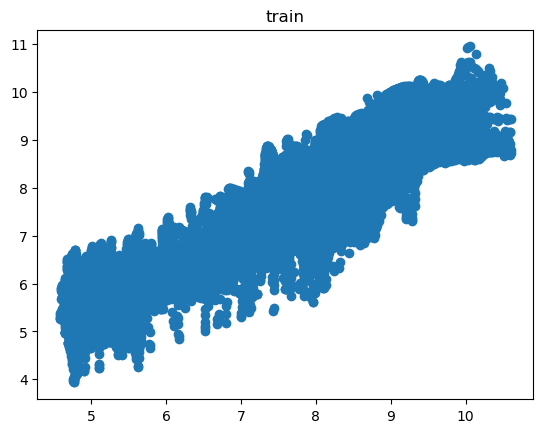

0.3034935475817554

In [40]:
plt.title(f"train")
plt.scatter(
    ds.Y_scaler.inverse_transform(Y_train),
    ds.Y_scaler.inverse_transform(model.predict(nystroem.transform(X_train[selected_features]))),
)
plt.show()

mean_squared_error(
    ds.Y_scaler.inverse_transform(Y_train),
    ds.Y_scaler.inverse_transform(model.predict(nystroem.transform(X_train[selected_features]))),
)

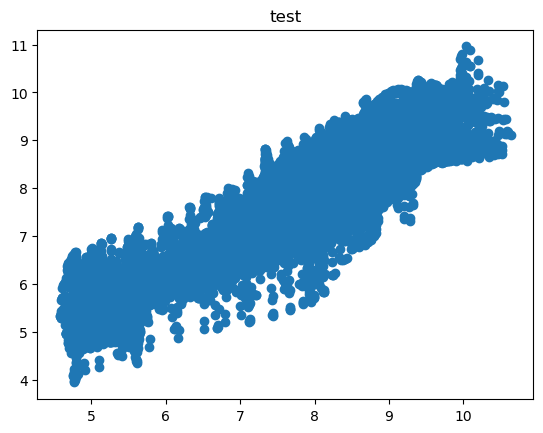

0.3213043518564109

In [41]:
plt.title(f"test")
plt.scatter(
    ds.Y_scaler.inverse_transform(Y_test),
    ds.Y_scaler.inverse_transform(model.predict(nystroem.transform(X_test[selected_features]))),
)
plt.show()

mean_squared_error(
    ds.Y_scaler.inverse_transform(Y_test),
    ds.Y_scaler.inverse_transform(model.predict(nystroem.transform(X_test[selected_features]))),
)

In [42]:
remaining_features = set(X_train_pr.columns)
selected_features = []

last_mse = 10.0
best_mse = 10.0

def mse_scorer(estimator, X, y):
    return mean_squared_error(y, estimator.predict(X))

while True:
    best_feature = None
    
    for feature in remaining_features:
        Xt = X_train_pr[selected_features + [feature]]
        Yt = Y_train_pr
        
        new_mse = np.mean(cross_validate(
            LinearPolyModel(), Xt, Yt, cv=8, n_jobs=8, scoring=mse_scorer,
        )["test_score"])
        
        if new_mse < best_mse:
            best_mse = new_mse
            best_feature = feature
            
            print(f"{new_mse:.03}: {', '.join(selected_features + [feature])}")
    
    print("========")
    
    if best_feature is None:
        break
        
    if (last_mse - best_mse) < 0.01:
        break
    
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    
    last_mse = best_mse

1.9: delta-ant_alcohols-3h-4l
1.87: delta-ant_alcohols-6h±1l
1.83: ant_ethene-1.5h+2l
1.6: ant_nox-48h+64l
1.12: delta-met_t-48h+64l
1.08: delta-met_t-12h+16l
1.07: delta-met_q-6h+8l
1.04: delta-met_t-24h+32l
1.0: delta-met_t-24h+32l, delta-ant_alcohols-6h±1l
0.925: delta-met_t-24h+32l, ant_nox-48h+64l
0.898: delta-met_t-24h+32l, met_t-0.5h-1l
0.89: delta-met_t-24h+32l, delta-ant_co-48h+64l
0.736: delta-met_t-24h+32l, met_t-24h+32l
0.735: delta-met_t-24h+32l, met_t-48h+64l
0.721: delta-met_t-24h+32l, met_t-48h+64l, ant_esters-6h-8l
0.716: delta-met_t-24h+32l, met_t-48h+64l, delta-met_t-48h+64l
0.707: delta-met_t-24h+32l, met_t-48h+64l, ant_benzene-48h±2l
0.705: delta-met_t-24h+32l, met_t-48h+64l, ant_toluene-24h±2l
0.704: delta-met_t-24h+32l, met_t-48h+64l, delta-ant_esters-3h+0l
0.695: delta-met_t-24h+32l, met_t-48h+64l, delta-met_q-6h+8l
0.609: delta-met_t-24h+32l, met_t-48h+64l, met_t-24h-32l
0.603: delta-met_t-24h+32l, met_t-48h+64l, met_t-24h-32l, bio_formaldehyde-0.5h+1l
0.583: d

In [43]:
print(selected_features)

nystroem = Nystroem(kernel="poly", degree=3, n_components=len(selected_features)*4, random_state=24).fit(
    X_train_pr[selected_features],
)
model = LinearRegression().fit(
    nystroem.transform(X_train_pr[selected_features]),
    Y_train_pr,
)

['delta-met_t-24h+32l', 'met_t-48h+64l', 'met_t-24h-32l', 'delta-bio_iosprene-3h-4l', 'delta-met_t-24h-32l', 'delta-met_t-48h-64l', 'delta-bio_co-3h-4l', 'delta-bio_co-3h+4l']


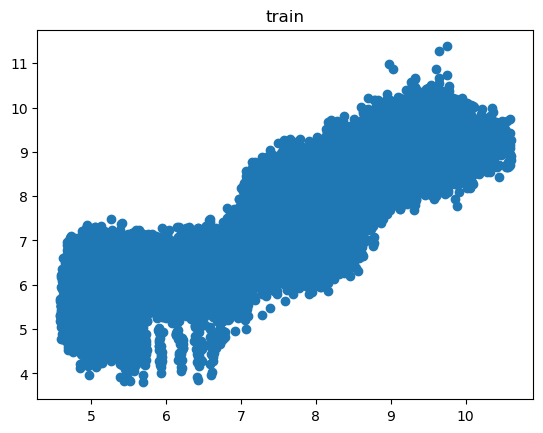

0.5142288681264972

In [44]:
rng = np.random.default_rng(42)

predictions = []

for _ in range(10):
    I3 = rng.choice(len(X_train), size=len(X_train))
    
    X_train_3 = pd.DataFrame(
        np.concatenate([
            ds.X_train,
            ds.X_train[I3] - ds.X_train,
        ], axis=1),
        columns=list(X_train.columns) + [f"delta-{f}" for f in X_train.columns],
    )
    
    predictions.append(
        ds.Y_train[I3] - model.predict(nystroem.transform(X_train_3[selected_features]))
    )

plt.title(f"train")
plt.scatter(
    ds.Y_scaler.inverse_transform(Y_train),
    ds.Y_scaler.inverse_transform(np.mean(np.stack(predictions, axis=0), axis=0)),
)
plt.show()
    
mean_squared_error(
    ds.Y_scaler.inverse_transform(Y_train),
    ds.Y_scaler.inverse_transform(np.mean(np.stack(predictions, axis=0), axis=0)),
)

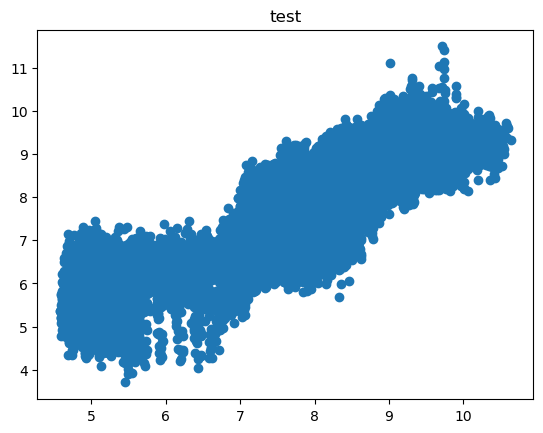

0.5271272028431426

In [45]:
rng = np.random.default_rng(42)

predictions = []

for _ in range(10):
    I3 = rng.choice(len(X_train), size=len(X_test))
    
    X_test_3 = pd.DataFrame(
        np.concatenate([
            ds.X_test,
            ds.X_train[I3] - ds.X_test,
        ], axis=1),
        columns=list(X_train.columns) + [f"delta-{f}" for f in X_train.columns],
    )
    
    predictions.append(
        ds.Y_train[I3] - model.predict(nystroem.transform(X_test_3[selected_features]))
    )
    
plt.title(f"test")
plt.scatter(
    ds.Y_scaler.inverse_transform(Y_test),
    ds.Y_scaler.inverse_transform(np.mean(np.stack(predictions, axis=0), axis=0)),
)
plt.show()

mean_squared_error(
    ds.Y_scaler.inverse_transform(Y_test),
    ds.Y_scaler.inverse_transform(np.mean(np.stack(predictions, axis=0), axis=0)),
)